# VISUALISE RESULTS

### Import relevant packages

In [1]:
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import numpy as np
import random

from sklearn.metrics import precision_recall_fscore_support, f1_score

sns.set(font_scale=1.3)
sns.set_style()

### Load results across test sets
Each "result" is a csv of gold labels and model predictions.
The results are stored in a nested dict: testset -> model -> train_size -> random_state (including "al" for active learning)

In [16]:
results_dict = dict()

SIZES = [0,10,20,30,40,50,100,200,300,400,500,1000,2000]
RANDOM_STATES = ["rs"+str(i) for i in range(1,11)]+["al", "full"]

for testset in sorted(os.listdir("./results")):
    if "hatecheck" not in testset:
        print(testset)
        results_dict[testset] = dict()
        
        for model in pd.unique([m.split("_")[0] for m in os.listdir(f"./results/{testset}")]):
            if "ipynb" not in model:
                print("  ", model)
                results_dict[testset][model] = dict()
                
                for size in SIZES:
                    results_dict[testset][model][size] = dict()
                    for random_state in RANDOM_STATES:
                        for filename in glob.glob(f"./results/{testset}/{model}_*_{size}_{random_state}.csv"):
                            results_dict[testset][model][size][random_state] = pd.read_csv(filename)
                
                # 0-shot xlmt models
                for filename in glob.glob(f"./results/{testset}/{model}*_20000_rs1.csv"):
                    results_dict[testset][model][0]["rs1"] = pd.read_csv(filename)

bas19_es_test_2000
   xlmr
   xlmt
   robertuito
for19_pt_test_2000
   xlmr
   bertimbau
   xlmt
ous19_ar_test_1000
   xlmr
   arabert
   xlmt
ous19_fr_test_1500
   camembert
   xlmr
   xlmt
san20_it_test_2000
   xlmt
   umberto
   xlmr


### Compute macro F1 for each model/testset combination

In [6]:
metrics_dict = copy.deepcopy(results_dict)

for testset in metrics_dict:
    print(testset)
    for model in metrics_dict[testset]:
        print(" ", model)
        for size in metrics_dict[testset][model]:
            for random_state in metrics_dict[testset][model][size]:
                metrics_dict[testset][model][size][random_state] = f1_score(metrics_dict[testset][model][size][random_state]["label"],
                                                                            metrics_dict[testset][model][size][random_state]["prediction"],
                                                                            average="macro")

bas19_es_test_2000
  xlmr
  xlmt
  robertuito
for19_pt_test_2000
  xlmr
  bertimbau
  xlmt
ous19_ar_test_1000
  xlmr
  arabert
  xlmt
  .ipynb
ous19_fr_test_1500
  camembert
  xlmr
  xlmt
san20_it_test_2000
  xlmt
  umberto
  xlmr


### Create flat df of results for easier plotting

In [7]:
metrics_df = pd.DataFrame(columns=["testset", "model", "train_size", "selection_strat", "macro_f1"])

for testset in metrics_dict:
    for model in metrics_dict[testset]:
        for size in metrics_dict[testset][model]:
            for selection_strat in metrics_dict[testset][model][size]:
                metrics_df.loc[len(metrics_df)+1] = [testset, model, size, selection_strat, metrics_dict[testset][model][size][selection_strat]]
                
metrics_df["sample"] = metrics_df.selection_strat.apply(lambda x: "active learning" if x=="al" else "random")

In [8]:
metrics_df = pd.DataFrame(columns=["testset", "model", "train_size", "selection_strat", "macro_f1"])

for testset in metrics_dict:
    for model in metrics_dict[testset]:
        for size in metrics_dict[testset][model]:
            for selection_strat in metrics_dict[testset][model][size]:
                metrics_df.loc[len(metrics_df)+1] = [testset, model, size, selection_strat, metrics_dict[testset][model][size][selection_strat]]

In [10]:
metrics_df[metrics_df.selection_strat=="]

,testset,model,train_size,selection_strat,macro_f1


### Average macro F1 across random seeds for same model/testset

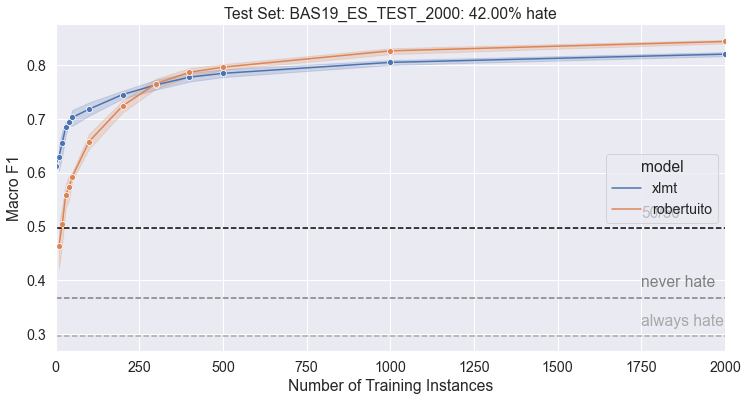

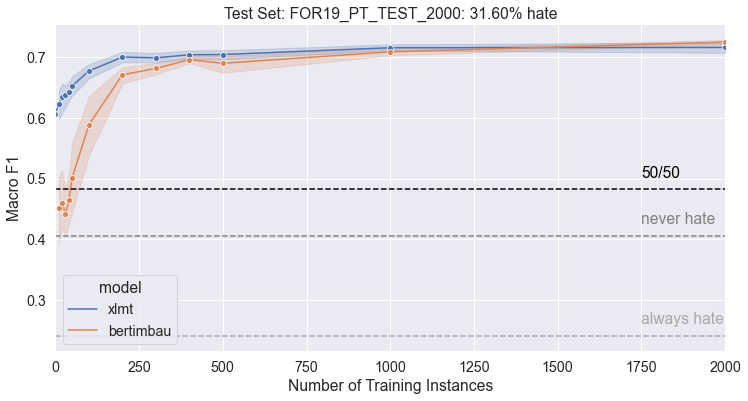

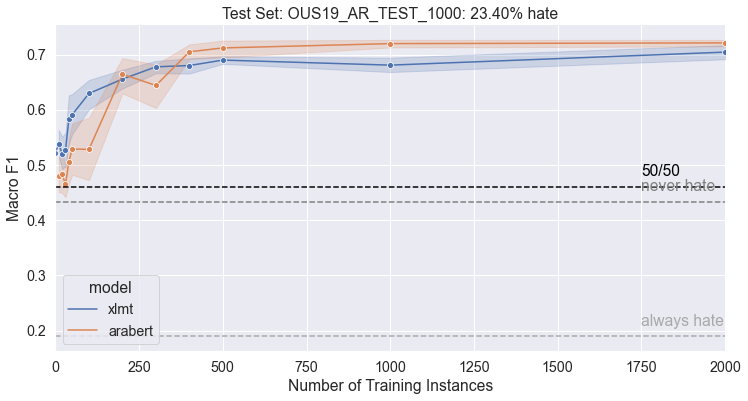

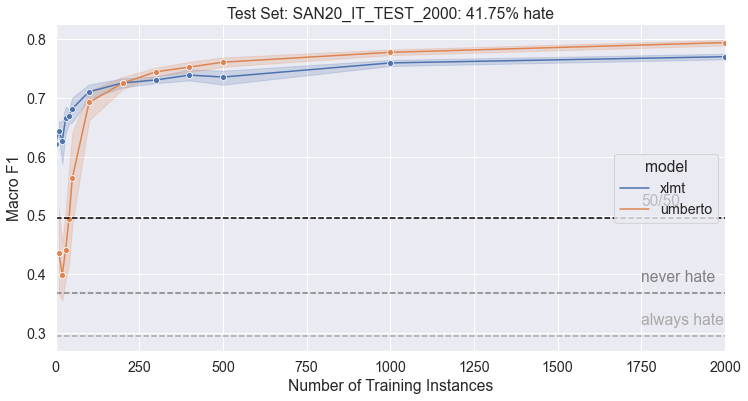

In [ ]:
for target_testset in sorted([t for t in metrics_dict.keys() if "fr" not in t]):

    f = plt.figure(figsize=(12,6))
    
    # Just random samples
    plot_df = metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat!="al")].sort_values(["model"], ascending=False)
    p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = plot_df, estimator="mean", marker="o", ci=95)
    
    # With AL samples
    #plot_df = metrics_df[(metrics_df.testset==target_testset) & (metrics_df.model!="xlmt")].sort_values(["model","sample"], ascending=False)
    #p = sns.lineplot(x="train_size", y="macro_f1", hue="model", style="sample", data = plot_df, estimator="mean", marker="o", ci=95)
    
    # Baseline: always hate
    always_hate = f1_score(results_dict[target_testset]['xlmt'][10]['rs1']["label"],len(results_dict[target_testset]['xlmt'][10]['rs1'])*[1], average="macro")
    p.axhline(always_hate, color="darkgrey", linestyle="--")
    p.annotate('always hate', xy= (1750,always_hate),  xytext=(1750,always_hate+0.02), color = "darkgrey")
    
    # Baseline: never hate
    never_hate = f1_score(results_dict[target_testset]['xlmt'][10]['rs1']["label"],len(results_dict[target_testset]['xlmt'][10]['rs1'])*[0], average="macro")
    p.axhline(never_hate, color="grey", linestyle="--")
    p.annotate('never hate', xy= (1750,never_hate),  xytext=(1750,never_hate+0.02), color="grey")
    
    # Baseline: 50/50 hate/nothate
    equal_prob = list()
    for i in range(1000):
        equal_prob += [f1_score(results_dict[target_testset]['xlmt'][10]['rs1']["label"],[round(random.uniform(0, 1)) for i in range(len(results_dict[target_testset]['xlmt'][10]['rs1']))], average="macro")]
    equal_prob = sum(equal_prob)/len(equal_prob)
    p.axhline(equal_prob, color="black", linestyle="--")
    p.annotate('50/50', xy= (1750,equal_prob),  xytext=(1750,equal_prob+0.02), color="black")
    
    p.set_title(f"Test Set: {target_testset.upper()}: {results_dict[target_testset]['xlmt'][10]['rs1'].label.mean():.2%} hate")
    p.set_xlabel("Number of Training Instances")
    p.set_ylabel("Macro F1")
    p.set_xlim(0,2000)
    sns.despine()
    plt.show()

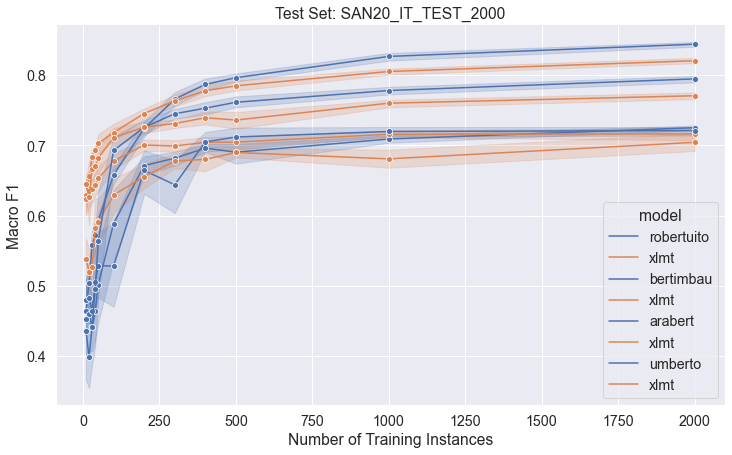

In [117]:
f = plt.figure(figsize=(12,7))

for target_testset in sorted([t for t in metrics_dict.keys() if "fr" not in t]):

    # exclude models trained on active learning "al" data
    plot_df = metrics_df[(metrics_df.testset == target_testset) & (metrics_df.selection_strat!="al")].sort_values("model")


    p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = plot_df,
                     estimator="mean", marker="o", ci=95)
    p.set_title(f"Test Set: {target_testset.upper()}")
    p.set_xlabel("Number of Training Instances")
    p.set_ylabel("Macro F1")
    sns.despine()
    #plt.show()